# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

env: CUDA_LAUNCH_BLOCKING=1


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_446698/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_446698/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_446698/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-24 21:59:12,042] A new study created in RDB with name: no-name-244c3bb3-dfc9-4384-a098-f1d1e5ea020d
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<11:16,  2.95it/s]

current_loss: tensor(1.4382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4556126594543457
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4454715251922607
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:15, 10.22it/s]

current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.435572624206543
current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4339500665664673
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4316470623016357
current_loss: tensor(1.3957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4313682317733765


  0%|          | 9/2000 [00:00<02:31, 13.15it/s]

current_loss: tensor(1.3956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4300566911697388
current_loss: tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4287261962890625
current_loss: tensor(1.3947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.429004430770874
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:18, 14.33it/s]

current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.428940773010254
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4286562204360962
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4281573295593262
current_loss: tensor(1.3945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:10, 15.24it/s]

current_loss_val:  1.4282687902450562
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.428165078163147
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.427685260772705
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4276808500289917
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:01, 16.27it/s]

current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4276841878890991
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4277174472808838
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4278100728988647
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:37, 12.61it/s]


current_loss_val:  1.428260326385498
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4284358024597168
Early Stop at iteration 20 with minimal loss tensor(1.4277, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:02,  6.60it/s]

current_loss_val:  1.3883750438690186
current_loss: tensor(1.3628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:29,  7.42it/s]

current_loss_val:  1.3275864124298096
current_loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3290, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:59,  6.67it/s]

current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3128859996795654
current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:38,  7.16it/s]

current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3083876371383667


  0%|          | 5/2000 [00:00<04:27,  7.46it/s]

current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3043767213821411
current_loss: tensor(1.2963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:41,  7.08it/s]

current_loss_val:  1.3016425371170044
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:31,  7.34it/s]

current_loss_val:  1.298909306526184
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:23,  7.56it/s]

current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2963507175445557
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 9/2000 [00:01<04:19,  7.68it/s]

tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2922337055206299


  0%|          | 10/2000 [00:01<04:15,  7.80it/s]

current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.289117455482483
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:12,  7.87it/s]

current_loss_val:  1.2883940935134888
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<05:10,  6.41it/s]

current_loss_val:  1.287479281425476
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<07:20,  4.51it/s]

current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2858688831329346
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<08:51,  3.74it/s]

current_loss_val:  1.2845486402511597
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<09:44,  3.39it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2842756509780884
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<10:23,  3.18it/s]

current_loss_val:  1.2841269969940186
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<11:10,  2.96it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2840404510498047
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<11:58,  2.76it/s]

current_loss_val:  1.2845971584320068
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<12:58,  2.54it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2845838069915771
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<13:25,  2.46it/s]

current_loss_val:  1.284503698348999
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<13:41,  2.41it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2842553853988647
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<13:56,  2.36it/s]

current_loss_val:  1.2838712930679321
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<14:19,  2.30it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2834913730621338
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<14:28,  2.27it/s]

current_loss_val:  1.2831767797470093
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<16:07,  2.04it/s]

current_loss_val:  1.2829747200012207
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<18:14,  1.80it/s]

current_loss_val:  1.2826883792877197
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:08<19:57,  1.65it/s]

current_loss_val:  1.2816927433013916
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:09<20:45,  1.58it/s]

current_loss_val:  1.2811241149902344
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:09<18:14,  1.80it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280411958694458
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:10<15:46,  2.08it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2770745754241943
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:10<13:47,  2.38it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759777307510376
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:10<12:08,  2.70it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275980830192566
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:10<10:59,  2.98it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759753465652466


  2%|▏         | 34/2000 [00:11<10:29,  3.13it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759464979171753
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:11<10:48,  3.03it/s]

current_loss_val:  1.2758619785308838
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:11<10:19,  3.17it/s]

current_loss_val:  1.2758105993270874
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:12<10:01,  3.27it/s]

current_loss_val:  1.2754502296447754
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:12<09:31,  3.43it/s]

current_loss_val:  1.2750664949417114
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:12<09:13,  3.54it/s]

current_loss_val:  1.2748926877975464
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:12<09:08,  3.57it/s]

current_loss_val:  1.2745237350463867
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:13<09:01,  3.62it/s]

current_loss_val:  1.273972988128662
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:13<08:36,  3.79it/s]

current_loss_val:  1.2735542058944702
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:13<08:32,  3.82it/s]

current_loss_val:  1.2734768390655518
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:13<08:38,  3.77it/s]

current_loss_val:  1.273406744003296
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:14<07:02,  4.62it/s]

current_loss_val:  1.2733120918273926
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732077836990356
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:14<05:29,  5.92it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732818126678467
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732843160629272


  2%|▏         | 49/2000 [00:14<05:03,  6.43it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732949256896973
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:14<09:39,  3.36it/s]

current_loss_val:  1.2733179330825806
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734414339065552
Early Stop at iteration 50 with minimal loss tensor(1.2732, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 21:59:31,356] Trial 0 finished with value: -2.5464155673980713 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.954057968852908, 'penalty_decorrelation_ridge_second_difference': 18.679623693960316}. Best is trial 0 with value: -2.5464155673980713.
  0%|          | 1/2000 [00:00<04:06,  8.10it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272470235824585
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:08,  8.02it/s]

current_loss_val:  1.2710109949111938
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269667625427246
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:08,  8.04it/s]

current_loss_val:  1.2693711519241333
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692811489105225
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268949270248413
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:32,  7.32it/s]

current_loss_val:  1.268722414970398
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686738967895508
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:35,  7.23it/s]

current_loss_val:  1.2685034275054932
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684890031814575
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:21,  7.61it/s]

current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681174278259277
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267850637435913


  1%|          | 13/2000 [00:01<04:16,  7.74it/s]

current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677700519561768
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:11,  7.90it/s]

current_loss_val:  1.2673523426055908
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267052173614502
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:08,  8.00it/s]

current_loss_val:  1.2669873237609863
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669591903686523
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:32,  7.27it/s]

current_loss_val:  1.2668733596801758
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266775131225586
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:18,  7.64it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266762614250183
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667075395584106


  1%|          | 22/2000 [00:02<04:14,  7.78it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266734004020691
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:36,  7.15it/s]

current_loss_val:  1.2666760683059692
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266592264175415
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:52,  6.74it/s]

current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665990591049194
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:28,  7.34it/s]

current_loss_val:  1.2662267684936523
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658323049545288
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:33,  7.21it/s]

current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659146785736084
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658474445343018
current_loss: 

  2%|▏         | 30/2000 [00:03<04:24,  7.44it/s]

tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655302286148071
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:15,  7.70it/s]

current_loss_val:  1.2650434970855713
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648801803588867
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:08,  7.91it/s]

current_loss_val:  1.2647277116775513
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647160291671753
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:05,  8.01it/s]

current_loss_val:  1.2647329568862915
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647441625595093
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:29,  7.28it/s]

current_loss_val:  1.2647358179092407
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647435665130615
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:47,  6.81it/s]

current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646690607070923
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:34,  7.15it/s]

current_loss_val:  1.2646905183792114
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<06:35,  4.96it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646411657333374
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:06<09:24,  3.47it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645927667617798
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<10:00,  3.26it/s]

current_loss_val:  1.2645410299301147
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:07<12:39,  2.57it/s]

current_loss_val:  1.2645007371902466
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:08<18:05,  1.80it/s]

current_loss_val:  1.2644627094268799
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:08<19:42,  1.65it/s]

current_loss_val:  1.2643826007843018
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:09<23:00,  1.42it/s]

current_loss_val:  1.2643684148788452
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:10<22:54,  1.42it/s]

current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264321208000183
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:10<20:28,  1.59it/s]

current_loss_val:  1.2642518281936646
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:11<20:36,  1.58it/s]

current_loss_val:  1.2641863822937012
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:12<20:16,  1.60it/s]

current_loss_val:  1.2638938426971436
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:12<18:23,  1.76it/s]

current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263909935951233
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:13<18:23,  1.76it/s]

current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638968229293823
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:13<16:40,  1.95it/s]

current_loss_val:  1.2638076543807983
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:13<14:13,  2.28it/s]

current_loss_val:  1.26349937915802
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:13<12:23,  2.62it/s]

current_loss_val:  1.2634446620941162
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:14<11:25,  2.84it/s]

current_loss_val:  1.2633163928985596
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:14<11:30,  2.81it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632478475570679
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:15<11:39,  2.78it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263169288635254


  3%|▎         | 60/2000 [00:15<10:33,  3.06it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631946802139282
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:15<10:45,  3.01it/s]

current_loss_val:  1.2631728649139404
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:15<11:03,  2.92it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631397247314453
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:16<10:18,  3.13it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630696296691895
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:16<09:42,  3.32it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263116478919983
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:16<09:25,  3.42it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631183862686157
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:17<08:48,  3.66it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631126642227173
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:17<08:42,  3.70it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262979507446289
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:17<09:22,  3.44it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629637718200684


  3%|▎         | 69/2000 [00:17<09:01,  3.57it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629812955856323


  4%|▎         | 70/2000 [00:17<07:33,  4.26it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629953622817993
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:18<06:56,  4.63it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629988193511963
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:18<05:44,  5.59it/s]

current_loss_val:  1.2629426717758179
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262905240058899
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:18<04:50,  6.63it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628620862960815
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628728151321411


  4%|▍         | 76/2000 [00:18<04:34,  7.00it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628756761550903
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:19<04:16,  7.49it/s]

current_loss_val:  1.262887954711914
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629053592681885
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:19<07:54,  4.05it/s]


current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629060745239258
Early Stop at iteration 78 with minimal loss tensor(1.2629, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 21:59:51,222] Trial 1 finished with value: -2.525724172592163 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8546697708684632, 'penalty_decorrelation_ridge_second_difference': 3.484205482509397}. Best is trial 1 with value: -2.525724172592163.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<24:57,  1.34it/s]

current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733874320983887


  0%|          | 2/2000 [00:01<17:01,  1.96it/s]

current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735607624053955
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:46,  3.79it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745610475540161
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752842903137207


  0%|          | 5/2000 [00:01<07:05,  4.68it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755099534988403
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:51,  3.06it/s]


current_loss_val:  1.2757068872451782
Early Stop at iteration 5 with minimal loss tensor(1.2734, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 21:59:53,562] Trial 2 finished with value: -2.5467748641967773 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.234896754493523, 'penalty_decorrelation_ridge_second_difference': 24.332388564130646}. Best is trial 1 with value: -2.525724172592163.
  0%|          | 1/2000 [00:00<04:13,  7.88it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725690603256226
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:11,  7.94it/s]

current_loss_val:  1.2709838151931763
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269986867904663
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:11,  7.93it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698328495025635
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:43,  5.80it/s]

current_loss_val:  1.2695400714874268
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692407369613647
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:52,  6.81it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691963911056519
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690998315811157


  0%|          | 9/2000 [00:01<04:38,  7.14it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687181234359741
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:25,  7.50it/s]

current_loss_val:  1.2684332132339478
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267987608909607
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:16,  7.73it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266985535621643
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666901350021362


  1%|          | 14/2000 [00:01<04:14,  7.80it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665332555770874
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:11,  7.87it/s]

current_loss_val:  1.2663503885269165
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663238048553467
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:09,  7.95it/s]

current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662224769592285
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660961151123047


  1%|          | 19/2000 [00:02<04:08,  7.97it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660632133483887
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:34,  7.20it/s]

current_loss_val:  1.2659512758255005
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657032012939453


  1%|          | 22/2000 [00:03<04:26,  7.42it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656216621398926
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:17,  7.67it/s]

current_loss_val:  1.2655636072158813
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654500007629395
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:39,  7.07it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652853727340698
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:25,  7.44it/s]

current_loss_val:  1.2652051448822021
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649275064468384
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:15,  7.71it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264620065689087
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644566297531128


  2%|▏         | 30/2000 [00:04<04:21,  7.54it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264380931854248
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:22,  7.50it/s]

current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643681764602661
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642744779586792


  2%|▏         | 33/2000 [00:04<04:44,  6.92it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642120122909546
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:26,  7.38it/s]

current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641915082931519
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264150619506836


  2%|▏         | 36/2000 [00:04<04:20,  7.54it/s]

current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640440464019775
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:33,  7.17it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640668153762817
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26395845413208


  2%|▏         | 39/2000 [00:05<04:26,  7.37it/s]

current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263935923576355
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<06:28,  5.05it/s]

current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639520168304443
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:06<08:59,  3.63it/s]

current_loss_val:  1.2638576030731201
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:06<13:09,  2.48it/s]

current_loss_val:  1.2637925148010254
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:07<16:20,  2.00it/s]

current_loss_val:  1.263771653175354
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:08<20:27,  1.59it/s]

current_loss_val:  1.263809323310852
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:09<21:17,  1.53it/s]

current_loss_val:  1.2637810707092285
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:09<21:33,  1.51it/s]

current_loss_val:  1.2637988328933716
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:10<20:20,  1.60it/s]

current_loss_val:  1.263818621635437
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:10<07:30,  4.33it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638442516326904
Early Stop at iteration 47 with minimal loss tensor(1.2638, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:05,413] Trial 3 finished with value: -2.527543306350708 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.566139399672274, 'penalty_decorrelation_ridge_second_difference': 7.039392892129167}. Best is trial 1 with value: -2.525724172592163.
  0%|          | 1/2000 [00:00<08:19,  4.00it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731900215148926


  0%|          | 2/2000 [00:00<08:36,  3.87it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732857465744019


  0%|          | 3/2000 [00:00<08:25,  3.95it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734118700027466


  0%|          | 4/2000 [00:01<08:50,  3.77it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737494707107544
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740755081176758


  0%|          | 5/2000 [00:01<08:48,  3.77it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:59,  3.03it/s]

current_loss_val:  1.2747248411178589
Early Stop at iteration 5 with minimal loss tensor(1.2732, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:08,277] Trial 4 finished with value: -2.546379566192627 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.070716519362396, 'penalty_decorrelation_ridge_second_difference': 5.66501647671148}. Best is trial 1 with value: -2.525724172592163.
  0%|          | 1/2000 [00:00<08:01,  4.15it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729190587997437
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272574543952942


  0%|          | 3/2000 [00:00<08:29,  3.92it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723537683486938


  0%|          | 4/2000 [00:01<08:36,  3.86it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720563411712646


  0%|          | 5/2000 [00:01<08:29,  3.92it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271594524383545


  0%|          | 6/2000 [00:01<08:16,  4.01it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271323323249817
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:04,  5.46it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710764408111572
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707847356796265


  0%|          | 9/2000 [00:01<05:29,  6.05it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703819274902344
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<04:49,  6.87it/s]

current_loss_val:  1.2700281143188477
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695225477218628
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<04:35,  7.21it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690093517303467
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<05:09,  6.42it/s]

current_loss_val:  1.2687088251113892
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686692476272583


  1%|          | 15/2000 [00:02<04:51,  6.82it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268620252609253
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<04:31,  7.31it/s]

current_loss_val:  1.2684495449066162
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683132886886597
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<04:19,  7.64it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686030864715576
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682627439498901


  1%|          | 20/2000 [00:03<04:16,  7.73it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680740356445312
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:27,  7.39it/s]

current_loss_val:  1.2679040431976318
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676570415496826
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:27,  7.39it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267136573791504
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669460773468018


  1%|▏         | 25/2000 [00:04<04:21,  7.54it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666326761245728
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<04:16,  7.70it/s]

current_loss_val:  1.266473650932312
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664836645126343
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:10,  7.86it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665491104125977
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666594982147217


  2%|▏         | 30/2000 [00:04<04:36,  7.12it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667487859725952
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<05:18,  6.18it/s]


current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668347358703613
Early Stop at iteration 30 with minimal loss tensor(1.2665, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:00:14,315] Trial 5 finished with value: -2.532947301864624 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.949276178308986, 'penalty_decorrelation_ridge_second_difference': 3.7902606784627513}. Best is trial 1 with value: -2.525724172592163.
  0%|          | 1/2000 [00:00<04:04,  8.17it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726346254348755
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:11,  7.93it/s]

current_loss_val:  1.2717621326446533
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695971727371216
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:11,  7.92it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690925598144531
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688148021697998


  0%|          | 6/2000 [00:00<04:11,  7.93it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686431407928467
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:12,  7.90it/s]

current_loss_val:  1.2684262990951538
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683019638061523
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:11,  7.92it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268100619316101
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267961025238037


  1%|          | 11/2000 [00:01<04:11,  7.90it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675310373306274
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:11,  7.90it/s]

current_loss_val:  1.2671294212341309
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669717073440552
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:10,  7.92it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669363021850586
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668850421905518


  1%|          | 16/2000 [00:02<04:08,  7.98it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667533159255981
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:18,  7.68it/s]

current_loss_val:  1.26677405834198
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667394876480103
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:23,  7.50it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666687965393066
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266633152961731


  1%|          | 21/2000 [00:02<04:20,  7.60it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665021419525146
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<04:16,  7.69it/s]

current_loss_val:  1.2663495540618896
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661769390106201
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:12,  7.81it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660605907440186
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658611536026


  1%|▏         | 26/2000 [00:03<04:09,  7.92it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654978036880493
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:11,  7.84it/s]

current_loss_val:  1.2655035257339478
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655014991760254
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<04:10,  7.87it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654403448104858
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265408992767334


  2%|▏         | 31/2000 [00:03<04:09,  7.88it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653272151947021
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:09,  7.87it/s]

current_loss_val:  1.265284776687622
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652039527893066
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:09,  7.89it/s]

current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651158571243286
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650973796844482


  2%|▏         | 36/2000 [00:04<04:06,  7.98it/s]

current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264973759651184
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<04:10,  7.83it/s]

current_loss_val:  1.2648707628250122
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648767232894897
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:09,  7.86it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648860216140747
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648733854293823


  2%|▏         | 41/2000 [00:05<04:08,  7.89it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648811340332031
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<04:11,  7.79it/s]

current_loss_val:  1.264869213104248
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648440599441528
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:05<04:04,  7.99it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648338079452515
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647995948791504
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<04:09,  7.82it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647500038146973
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646470069885254


  2%|▏         | 48/2000 [00:06<04:09,  7.84it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646267414093018
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:06<04:10,  7.80it/s]

current_loss_val:  1.2644789218902588
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641047239303589
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:06<04:07,  7.86it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640042304992676
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263816475868225


  3%|▎         | 53/2000 [00:06<04:33,  7.13it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637463808059692
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:07<04:20,  7.47it/s]

current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637131214141846
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637027502059937


  3%|▎         | 56/2000 [00:07<04:15,  7.60it/s]

current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637263536453247
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:07<04:12,  7.70it/s]

current_loss_val:  1.2636638879776
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636327743530273
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:07<04:07,  7.83it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635893821716309
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634944915771484


  3%|▎         | 61/2000 [00:07<04:07,  7.84it/s]

current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634756565093994
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:08<04:07,  7.83it/s]

current_loss_val:  1.2634483575820923
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634055614471436
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:08<04:03,  7.95it/s]

current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263396978378296
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263386845588684


  3%|▎         | 66/2000 [00:08<04:06,  7.86it/s]

current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633496522903442
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:08<04:07,  7.82it/s]

current_loss_val:  1.2633293867111206
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263318419456482
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:08<04:05,  7.85it/s]

current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632827758789062
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263182282447815


  4%|▎         | 71/2000 [00:09<04:05,  7.86it/s]

current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631497383117676
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:09<04:06,  7.80it/s]

current_loss_val:  1.26314115524292
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631253004074097
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:09<04:05,  7.86it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630836963653564
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630891799926758


  4%|▍         | 76/2000 [00:09<04:04,  7.88it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630903720855713
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:09<04:05,  7.82it/s]

current_loss_val:  1.2630804777145386
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630836963653564
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:10<04:04,  7.86it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263084053993225
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630659341812134


  4%|▍         | 81/2000 [00:10<04:04,  7.86it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630558013916016
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:10<05:34,  5.73it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630257606506348


  4%|▍         | 83/2000 [00:10<06:40,  4.78it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262995958328247
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:11<07:38,  4.17it/s]

current_loss_val:  1.2628867626190186
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:11<08:37,  3.70it/s]

current_loss_val:  1.262769103050232
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:11<09:38,  3.31it/s]

current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626582384109497
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:12<09:43,  3.28it/s]

current_loss_val:  1.2624536752700806
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:12<10:39,  2.99it/s]

current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262396216392517
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:13<12:02,  2.65it/s]

current_loss_val:  1.2623957395553589
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:13<12:24,  2.57it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624001502990723
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:13<12:29,  2.55it/s]

current_loss_val:  1.262391448020935
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:14<12:42,  2.50it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262397289276123
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:14<12:40,  2.51it/s]

current_loss_val:  1.2623977661132812
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:15<12:54,  2.46it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262393832206726
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:15<12:57,  2.45it/s]

current_loss_val:  1.262404441833496
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:16<05:22,  5.91it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624082565307617
Early Stop at iteration 95 with minimal loss tensor(1.2624, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:32,261] Trial 6 finished with value: -2.524782657623291 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9972110946603214, 'penalty_decorrelation_ridge_second_difference': 15.442601202100558}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<10:46,  3.09it/s]

current_loss_val:  1.2732738256454468
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:47,  3.40it/s]

current_loss_val:  1.2733372449874878
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:25,  3.53it/s]

current_loss_val:  1.2737141847610474
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:29,  3.92it/s]

current_loss_val:  1.2740477323532104
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:17,  3.58it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741084098815918
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:06,  2.99it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741531133651733
Early Stop at iteration 5 with minimal loss tensor(1.2733, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:35,217] Trial 7 finished with value: -2.5465476512908936 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.485882206526167, 'penalty_decorrelation_ridge_second_difference': 26.028717137171082}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731610536575317
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731190919876099
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727817296981812


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272165060043335
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:22,  7.60it/s]

current_loss_val:  1.2720361948013306
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719148397445679
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:13,  7.85it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715662717819214
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271127462387085


  0%|          | 9/2000 [00:01<04:17,  7.74it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270803451538086
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:17,  7.73it/s]

current_loss_val:  1.2702385187149048
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697266340255737
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:16,  7.76it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691141366958618
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685259580612183


  1%|          | 14/2000 [00:01<04:14,  7.79it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26799738407135
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:15,  7.75it/s]

current_loss_val:  1.2675827741622925
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671748399734497
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:14,  7.80it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667649984359741
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666068077087402


  1%|          | 19/2000 [00:02<04:13,  7.81it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26642906665802
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:32,  7.25it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662267684936523
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660937309265137


  1%|          | 22/2000 [00:02<04:27,  7.39it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265872597694397
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:21,  7.54it/s]

current_loss_val:  1.265597939491272
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653294801712036
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:16,  7.71it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653756141662598
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654101848602295


  1%|▏         | 27/2000 [00:03<04:14,  7.76it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654699087142944
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:30,  7.29it/s]

current_loss_val:  1.2654846906661987
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655166387557983
Early Stop at iteration 28 with minimal loss tensor(1.2653, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:40,323] Trial 8 finished with value: -2.5306591987609863 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.4892934306, 'penalty_decorrelation_ridge_second_difference': 26.041916912173793}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:05,  8.14it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735198736190796
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:03,  8.20it/s]

current_loss_val:  1.273758888244629
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745015621185303
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275283932685852
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276172399520874


  0%|          | 5/2000 [00:00<05:03,  6.56it/s]


current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.277182936668396
Early Stop at iteration 5 with minimal loss tensor(1.2735, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:00:42,532] Trial 9 finished with value: -2.54703950881958 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.641118059597947, 'penalty_decorrelation_ridge_second_difference': 11.467405923501019}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<05:37,  5.93it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273208498954773
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.29it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732319831848145
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733542919158936


  0%|          | 4/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273540735244751
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:23,  6.17it/s]

current_loss_val:  1.2735049724578857
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734912633895874
Early Stop at iteration 5 with minimal loss tensor(1.2732, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:44,864] Trial 10 finished with value: -2.546416759490967 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.78099923119598, 'penalty_decorrelation_ridge_second_difference': 15.129507405498442}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731143236160278
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:38,  7.18it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730430364608765
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724794149398804


  0%|          | 4/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718600034713745
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:22,  7.59it/s]

current_loss_val:  1.2716320753097534
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714201211929321
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:19,  7.68it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708895206451416
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700988054275513


  0%|          | 9/2000 [00:01<04:25,  7.51it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699698209762573
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:33,  7.26it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269852876663208
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695742845535278


  1%|          | 12/2000 [00:01<04:27,  7.42it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691620588302612
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:24,  7.51it/s]

current_loss_val:  1.2688076496124268
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683051824569702
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:20,  7.63it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676541805267334
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674709558486938


  1%|          | 17/2000 [00:02<04:18,  7.67it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673799991607666
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:17,  7.68it/s]

current_loss_val:  1.2670801877975464
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667077779769897
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:15,  7.75it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666268348693848
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665191888809204


  1%|          | 22/2000 [00:02<04:14,  7.77it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663605213165283
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:15,  7.73it/s]

current_loss_val:  1.2660386562347412
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658984661102295
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:14,  7.75it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658686637878418
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658257484436035


  1%|▏         | 27/2000 [00:03<04:14,  7.76it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265763759613037
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:15,  7.72it/s]

current_loss_val:  1.2657173871994019
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657071352005005
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:12,  7.79it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265755534172058
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26590895652771


  2%|▏         | 32/2000 [00:04<04:38,  7.06it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659856081008911
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:28,  7.33it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266025424003601
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661736011505127
Early Stop at iteration 33 with minimal loss tensor(1.2657, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:00:50,742] Trial 11 finished with value: -2.531414031982422 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.743942778417225, 'penalty_decorrelation_ridge_second_difference': 17.859588103845095}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:10,  7.99it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731958627700806
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:13,  7.86it/s]

current_loss_val:  1.2732117176055908
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732213735580444
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:15,  7.81it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732316255569458
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273295283317566


  0%|          | 5/2000 [00:00<05:02,  6.59it/s]


current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734802961349487
Early Stop at iteration 5 with minimal loss tensor(1.2732, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:00:52,514] Trial 12 finished with value: -2.546391487121582 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.70170708249977, 'penalty_decorrelation_ridge_second_difference': 13.667226287962196}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:05,  8.15it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735695838928223
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:13,  7.87it/s]

current_loss_val:  1.2737178802490234
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740381956100464
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.83it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274430274963379
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2762192487716675


  0%|          | 5/2000 [00:00<05:01,  6.62it/s]


current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276398777961731
Early Stop at iteration 5 with minimal loss tensor(1.2736, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:00:54,665] Trial 13 finished with value: -2.5471394062042236 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.881255118618082, 'penalty_decorrelation_ridge_second_difference': 13.928627706463008}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:09,  8.02it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732049226760864
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:17,  7.77it/s]

current_loss_val:  1.2732247114181519
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273241639137268
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.79it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273260474205017
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733920812606812


  0%|          | 5/2000 [00:00<05:05,  6.53it/s]


current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736419439315796
Early Stop at iteration 5 with minimal loss tensor(1.2732, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:00:56,860] Trial 14 finished with value: -2.5464096069335938 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.216936010796974, 'penalty_decorrelation_ridge_second_difference': 13.090386811664667}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:09,  8.02it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727562189102173
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:16,  7.80it/s]

current_loss_val:  1.2725492715835571
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717866897583008
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:12,  7.90it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707635164260864
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:41,  7.09it/s]

current_loss_val:  1.2698414325714111
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269343614578247
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:27,  7.45it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684485912322998
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680307626724243
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:46,  5.75it/s]

current_loss_val:  1.267920970916748
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675697803497314
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:59,  6.65it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671093940734863
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266801357269287
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<06:07,  5.40it/s]

current_loss_val:  1.2665928602218628
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26607346534729
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<06:13,  5.32it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658826112747192
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:16,  6.27it/s]

current_loss_val:  1.2658483982086182
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656244039535522
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<05:24,  6.11it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265533685684204
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<04:50,  6.81it/s]

current_loss_val:  1.2654199600219727
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651095390319824
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:33,  7.24it/s]

current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651804685592651
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652318477630615


  1%|          | 23/2000 [00:03<04:27,  7.40it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652872800827026
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<05:12,  6.33it/s]

current_loss_val:  1.2653281688690186
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653709650039673
Early Stop at iteration 24 with minimal loss tensor(1.2651, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:01:02,031] Trial 15 finished with value: -2.530219078063965 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.213101542697802, 'penalty_decorrelation_ridge_second_difference': 19.109186971874117}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:07,  8.08it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725393772125244
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:14,  7.84it/s]

current_loss_val:  1.270995855331421
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699633836746216
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697218656539917
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696579694747925


  0%|          | 6/2000 [00:00<04:18,  7.71it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693471908569336
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:38,  7.16it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269065022468567
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690280675888062


  0%|          | 9/2000 [00:01<04:31,  7.34it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690068483352661
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:26,  7.45it/s]

current_loss_val:  1.2689688205718994
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26870858669281
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:20,  7.62it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676448822021484
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671016454696655


  1%|          | 14/2000 [00:01<04:18,  7.67it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266538381576538
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:38,  7.12it/s]

current_loss_val:  1.2663999795913696
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266459584236145
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:26,  7.44it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670446634292603
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669079303741455


  1%|          | 19/2000 [00:02<04:24,  7.50it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266849160194397
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:37,  7.14it/s]


current_loss_val:  1.266697883605957
Early Stop at iteration 19 with minimal loss tensor(1.2664, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:01:06,214] Trial 16 finished with value: -2.53279972076416 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.255400267485802, 'penalty_decorrelation_ridge_second_difference': 0.9277683423024548}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<05:53,  5.65it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725846767425537
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:40,  7.12it/s]

current_loss_val:  1.2714444398880005
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692166566848755
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<09:21,  3.55it/s]

current_loss_val:  1.2687911987304688
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:03,  3.31it/s]

current_loss_val:  1.2685006856918335
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682712078094482
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:55,  4.79it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679710388183594
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267764925956726


  0%|          | 9/2000 [00:02<06:05,  5.44it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675151824951172
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<05:13,  6.35it/s]

current_loss_val:  1.2671048641204834
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669126987457275
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:44,  6.98it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668049335479736
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663428783416748


  1%|          | 14/2000 [00:02<04:35,  7.20it/s]

current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662585973739624
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:27,  7.41it/s]

current_loss_val:  1.266198992729187
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661689519882202
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<04:28,  7.38it/s]

current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266128420829773
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26590895652771


  1%|          | 19/2000 [00:03<04:40,  7.06it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658494710922241
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<04:29,  7.33it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658131122589111
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657294273376465


  1%|          | 22/2000 [00:03<04:25,  7.46it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265668511390686
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:04<04:12,  7.82it/s]

current_loss_val:  1.2656445503234863
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656389474868774
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<04:25,  7.44it/s]

current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265624761581421
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265442967414856


  1%|▏         | 27/2000 [00:04<04:22,  7.52it/s]

current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653963565826416
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:17,  7.66it/s]

current_loss_val:  1.2653437852859497
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265323519706726
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:17,  7.65it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653682231903076
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653948068618774


  2%|▏         | 32/2000 [00:05<04:16,  7.67it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26543390750885
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:05<05:17,  6.19it/s]

current_loss_val:  1.265464186668396
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265387773513794
Early Stop at iteration 33 with minimal loss tensor(1.2653, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:01:12,482] Trial 17 finished with value: -2.530646800994873 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.36463041479460356, 'penalty_decorrelation_ridge_second_difference': 15.491603695068667}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<10:47,  3.09it/s]

current_loss_val:  1.2727935314178467
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<11:37,  2.87it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724295854568481


  0%|          | 3/2000 [00:01<11:26,  2.91it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712275981903076


  0%|          | 4/2000 [00:01<10:25,  3.19it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270280122756958


  0%|          | 5/2000 [00:01<09:43,  3.42it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697573900222778


  0%|          | 6/2000 [00:01<09:28,  3.50it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696036100387573


  0%|          | 7/2000 [00:02<09:16,  3.58it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691724300384521


  0%|          | 8/2000 [00:02<09:07,  3.64it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268683910369873


  0%|          | 9/2000 [00:02<09:17,  3.57it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683765888214111


  0%|          | 10/2000 [00:02<08:59,  3.69it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681849002838135


  1%|          | 11/2000 [00:03<08:57,  3.70it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267593264579773
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<14:08,  2.34it/s]

current_loss_val:  1.2673591375350952
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672678232192993


  1%|          | 13/2000 [00:04<16:08,  2.05it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:05<17:25,  1.90it/s]

current_loss_val:  1.2666641473770142
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:06<20:15,  1.63it/s]

current_loss_val:  1.2666122913360596
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665528059005737


  1%|          | 16/2000 [00:06<20:09,  1.64it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:07<20:17,  1.63it/s]

current_loss_val:  1.2664029598236084
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 18/2000 [00:07<20:04,  1.65it/s]

tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266161322593689


  1%|          | 19/2000 [00:08<16:32,  2.00it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659170627593994


  1%|          | 20/2000 [00:08<14:04,  2.35it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265848994255066


  1%|          | 21/2000 [00:08<12:29,  2.64it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657201290130615
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:08<11:44,  2.81it/s]

current_loss_val:  1.2658251523971558
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:09<10:41,  3.08it/s]

current_loss_val:  1.265693187713623
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:09<09:59,  3.30it/s]

current_loss_val:  1.265607237815857
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:09<09:52,  3.33it/s]

current_loss_val:  1.265518069267273
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:10<10:10,  3.23it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655469179153442
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:10<09:53,  3.32it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655004262924194
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:10<09:32,  3.44it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653894424438477
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:11<11:31,  2.85it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653369903564453
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:11<11:59,  2.74it/s]

current_loss_val:  1.2653225660324097
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:11<12:00,  2.73it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652009725570679
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:12<13:24,  2.44it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652394771575928
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:12<13:12,  2.48it/s]

current_loss_val:  1.2652453184127808
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:13<13:47,  2.38it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26533043384552
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:13<14:25,  2.27it/s]

current_loss_val:  1.2654818296432495
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:14<13:12,  2.48it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654212713241577
Early Stop at iteration 35 with minimal loss tensor(1.2652, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:01:27,478] Trial 18 finished with value: -2.5304017066955566 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.93121790582391, 'penalty_decorrelation_ridge_second_difference': 13.32871796782136}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<13:32,  2.46it/s]

current_loss_val:  1.2724336385726929
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:37,  3.13it/s]

current_loss_val:  1.2711265087127686
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:46,  3.41it/s]

current_loss_val:  1.2696385383605957
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:27,  3.52it/s]

current_loss_val:  1.2692327499389648
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:21,  3.55it/s]

current_loss_val:  1.269116997718811
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:04,  3.66it/s]

current_loss_val:  1.2686874866485596
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:47,  3.39it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268465518951416
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:21,  3.55it/s]

current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684165239334106
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:08,  3.63it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682175636291504
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:46,  3.39it/s]

current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681580781936646


  1%|          | 11/2000 [00:03<09:26,  3.51it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679451704025269


  1%|          | 12/2000 [00:03<09:08,  3.62it/s]

current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670429944992065


  1%|          | 13/2000 [00:03<09:06,  3.64it/s]

current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267114281654358


  1%|          | 14/2000 [00:03<08:52,  3.73it/s]

current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668042182922363


  1%|          | 15/2000 [00:04<08:38,  3.83it/s]

current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266745924949646


  1%|          | 16/2000 [00:04<08:42,  3.80it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666429281234741
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:17,  3.56it/s]

current_loss_val:  1.2666618824005127
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<09:09,  3.61it/s]

current_loss_val:  1.2666369676589966
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:03,  3.64it/s]

current_loss_val:  1.2665196657180786
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:12,  3.58it/s]

current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664361000061035
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:07,  4.63it/s]

current_loss_val:  1.2662910223007202
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662538290023804
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<05:32,  5.94it/s]

current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659804821014404
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658684253692627
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<05:09,  6.38it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652795314788818
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:06<05:10,  6.36it/s]

current_loss_val:  1.2652559280395508
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652899026870728
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:06<04:43,  6.96it/s]

current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654783725738525
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656694650650024


  2%|▏         | 30/2000 [00:07<04:35,  7.16it/s]

current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653608322143555
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<04:28,  7.33it/s]

current_loss_val:  1.26506769657135
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264840006828308
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:07<04:21,  7.53it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648180723190308
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647405862808228


  2%|▏         | 35/2000 [00:07<04:18,  7.59it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647783756256104
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:07<04:20,  7.52it/s]

current_loss_val:  1.264741063117981
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644517421722412
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:08<04:18,  7.60it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642405033111572
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642548084259033


  2%|▏         | 40/2000 [00:08<04:16,  7.63it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643728256225586
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:08<04:31,  7.22it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644309997558594
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643978595733643


  2%|▏         | 43/2000 [00:08<04:31,  7.22it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642126083374023
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:09<04:43,  6.90it/s]

current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641708850860596
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641505002975464


  2%|▏         | 46/2000 [00:09<04:34,  7.12it/s]

current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640458345413208
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:09<04:23,  7.42it/s]

current_loss_val:  1.2639803886413574
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26396906375885
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:09<04:21,  7.45it/s]

current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639790773391724
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639796733856201


  3%|▎         | 51/2000 [00:09<04:45,  6.84it/s]

current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263951301574707
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:10<04:32,  7.15it/s]

current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263950228691101
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263941764831543


  3%|▎         | 54/2000 [00:10<04:52,  6.66it/s]

current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263972282409668
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:10<04:26,  7.29it/s]

current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639522552490234
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638428211212158
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:10<04:23,  7.37it/s]

current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263845682144165
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637789249420166


  3%|▎         | 59/2000 [00:11<04:20,  7.45it/s]

current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637616395950317
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:11<04:41,  6.89it/s]

current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637776136398315
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637439966201782


  3%|▎         | 62/2000 [00:11<04:33,  7.10it/s]

current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637239694595337
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:11<04:52,  6.61it/s]

current_loss_val:  1.263666033744812
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636325359344482


  3%|▎         | 65/2000 [00:11<04:40,  6.90it/s]

current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635481357574463
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:12<04:30,  7.15it/s]

current_loss_val:  1.263440728187561
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263370156288147
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:12<04:45,  6.76it/s]

current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633082866668701
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:12<04:35,  6.99it/s]

current_loss_val:  1.2632921934127808
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632241249084473
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:12<04:54,  6.56it/s]

current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263224482536316
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:13<04:54,  6.54it/s]

current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632066011428833
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630352973937988


  4%|▎         | 74/2000 [00:13<05:07,  6.27it/s]

current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629969120025635
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:13<05:53,  5.44it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629503011703491
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:13<05:33,  5.77it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628947496414185
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:14<08:09,  3.93it/s]

current_loss_val:  1.2628411054611206
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:14<08:56,  3.58it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628079652786255
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:14<06:39,  4.80it/s]

current_loss_val:  1.262772560119629
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627449035644531
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:14<06:20,  5.04it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262765645980835
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:15<05:08,  6.22it/s]

current_loss_val:  1.2627782821655273
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627884149551392
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:15<05:00,  6.37it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627500295639038
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:15<05:20,  5.97it/s]

current_loss_val:  1.2627296447753906
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627246379852295


  4%|▍         | 87/2000 [00:15<04:55,  6.47it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627232074737549
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:15<05:17,  6.03it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627263069152832
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:16<05:08,  6.19it/s]

current_loss_val:  1.2627251148223877
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627404928207397
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:16<04:46,  6.65it/s]

current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627085447311401
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:16<04:45,  6.69it/s]

current_loss_val:  1.2627174854278564
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627297639846802


  5%|▍         | 94/2000 [00:16<05:26,  5.84it/s]

current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627805471420288


  5%|▍         | 95/2000 [00:17<06:21,  4.99it/s]

current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627654075622559
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:17<05:50,  5.43it/s]

current_loss_val:  1.2627599239349365
Early Stop at iteration 95 with minimal loss tensor(1.2627, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:01:45,702] Trial 19 finished with value: -2.5254170894622803 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.31225180794293617, 'penalty_decorrelation_ridge_second_difference': 4.197441443841757}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:10,  7.98it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728663682937622
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:20,  7.67it/s]

current_loss_val:  1.2725944519042969
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718908786773682
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:22,  7.59it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271011233329773
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704031467437744


  0%|          | 6/2000 [00:00<04:16,  7.76it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701268196105957
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:28,  7.42it/s]

current_loss_val:  1.2699775695800781
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695585489273071
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:27,  7.44it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691066265106201
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:30,  7.34it/s]

current_loss_val:  1.2688660621643066
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683372497558594
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:26,  7.45it/s]

current_loss_val:  1.2679500579833984
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267482876777649
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:31,  7.31it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672078609466553
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266687035560608


  1%|          | 16/2000 [00:02<04:28,  7.38it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665698528289795
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:28,  7.39it/s]

current_loss_val:  1.2664201259613037
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664363384246826
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:19,  7.63it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665141820907593
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667919397354126


  1%|          | 21/2000 [00:02<04:25,  7.46it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668718099594116
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:36,  7.15it/s]


current_loss_val:  1.2669001817703247
Early Stop at iteration 21 with minimal loss tensor(1.2664, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:01:49,406] Trial 20 finished with value: -2.532839775085449 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.237634676816647, 'penalty_decorrelation_ridge_second_difference': 10.893421724277676}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:11,  7.93it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724107503890991
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:03,  6.59it/s]

current_loss_val:  1.2718462944030762
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699226140975952


  0%|          | 4/2000 [00:00<04:47,  6.95it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696374654769897
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:31,  7.34it/s]

current_loss_val:  1.2681045532226562
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679468393325806
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:03,  6.57it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678126096725464
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:18,  6.26it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676953077316284
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:15,  6.31it/s]

current_loss_val:  1.267980694770813
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676665782928467
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:49,  6.88it/s]

current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674646377563477
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267120599746704


  1%|          | 13/2000 [00:01<04:40,  7.08it/s]

current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668370008468628
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:34,  7.24it/s]

current_loss_val:  1.2668955326080322
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671055793762207
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:27,  7.41it/s]

current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671689987182617
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267160177230835


  1%|          | 18/2000 [00:02<04:20,  7.61it/s]

current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667509317398071
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<05:01,  6.56it/s]

current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666844129562378
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666164636611938


  1%|          | 21/2000 [00:03<04:49,  6.83it/s]

current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266345739364624
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<05:07,  6.44it/s]

current_loss_val:  1.2662405967712402
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662111520767212


  1%|          | 24/2000 [00:03<04:52,  6.75it/s]

current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662639617919922
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:39,  7.05it/s]

current_loss_val:  1.266297698020935
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266178011894226
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:59,  6.59it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660049200057983
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:40,  7.03it/s]

current_loss_val:  1.2657811641693115
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654106616973877
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:33,  7.21it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265255331993103
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650176286697388


  2%|▏         | 32/2000 [00:04<04:28,  7.32it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646450996398926
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:22,  7.49it/s]

current_loss_val:  1.26430344581604
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639470100402832
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<04:26,  7.38it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637828588485718
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634514570236206


  2%|▏         | 37/2000 [00:05<04:49,  6.78it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263979196548462
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:39,  7.02it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641355991363525
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264039397239685


  2%|▏         | 40/2000 [00:05<04:33,  7.17it/s]

current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263830542564392
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:47,  6.83it/s]


current_loss_val:  1.2636945247650146
Early Stop at iteration 40 with minimal loss tensor(1.2635, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:01:56,008] Trial 21 finished with value: -2.526902914047241 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7636769598849406, 'penalty_decorrelation_ridge_second_difference': 1.3558990362385663}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<05:46,  5.77it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730581760406494
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:46,  6.96it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729185819625854
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715986967086792


  0%|          | 4/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269822597503662
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:34,  7.26it/s]

current_loss_val:  1.269868016242981
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698498964309692
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:29,  7.39it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269788146018982
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697334289550781
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<06:07,  5.42it/s]

current_loss_val:  1.2697224617004395
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269711971282959
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<06:02,  5.48it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696256637573242
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<05:11,  6.38it/s]

current_loss_val:  1.2695544958114624
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2689900398254395
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:51,  6.80it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685834169387817
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686187028884888


  1%|          | 16/2000 [00:02<04:42,  7.02it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268602728843689
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<05:02,  6.54it/s]

current_loss_val:  1.2685511112213135
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268530249595642


  1%|          | 19/2000 [00:02<04:50,  6.81it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684993743896484
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<05:06,  6.46it/s]

current_loss_val:  1.2683192491531372
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682979106903076


  1%|          | 22/2000 [00:03<04:47,  6.88it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268288254737854
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:42,  6.99it/s]

current_loss_val:  1.2682019472122192
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679955959320068
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:56,  6.66it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676351070404053
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<04:47,  6.87it/s]

current_loss_val:  1.2673879861831665
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668215036392212
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<05:05,  6.46it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663440704345703
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:47,  6.85it/s]

current_loss_val:  1.2660869359970093
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652901411056519
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<05:05,  6.44it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650669813156128
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:32,  7.21it/s]

current_loss_val:  1.26494300365448
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642914056777954
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<04:49,  6.78it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642250061035156
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264191746711731


  2%|▏         | 36/2000 [00:05<04:40,  7.00it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264051079750061
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:34,  7.15it/s]

current_loss_val:  1.2638180255889893
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263893961906433
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:30,  7.26it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640266418457031
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640254497528076


  2%|▏         | 41/2000 [00:06<04:26,  7.36it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640159130096436
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:06<04:56,  6.60it/s]


current_loss_val:  1.2639665603637695
Early Stop at iteration 41 with minimal loss tensor(1.2638, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:02,916] Trial 22 finished with value: -2.5276362895965576 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.8481448032909804, 'penalty_decorrelation_ridge_second_difference': 27.84434857398426}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:10,  7.97it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725934982299805
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:22,  7.60it/s]

current_loss_val:  1.2711050510406494
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700430154800415
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697783708572388
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690606117248535


  0%|          | 6/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686048746109009
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:29,  7.40it/s]

current_loss_val:  1.2684271335601807
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683076858520508
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:28,  7.41it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676453590393066
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:45,  6.97it/s]

current_loss_val:  1.2673717737197876
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267316460609436
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:35,  7.21it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671109437942505
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266993761062622


  1%|          | 14/2000 [00:01<04:32,  7.29it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26699960231781
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:33,  7.25it/s]

current_loss_val:  1.2668689489364624
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668265104293823
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:30,  7.32it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667819261550903
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26661217212677


  1%|          | 19/2000 [00:02<04:28,  7.38it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266385555267334
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:32,  7.27it/s]

current_loss_val:  1.2661768198013306
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659964561462402
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:27,  7.38it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656084299087524
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655003070831299


  1%|          | 24/2000 [00:03<04:25,  7.43it/s]

current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265176773071289
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:28,  7.34it/s]

current_loss_val:  1.2649116516113281
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648406028747559
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:26,  7.41it/s]

current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648367881774902
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646838426589966


  1%|▏         | 29/2000 [00:03<04:24,  7.44it/s]

current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264474868774414
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:22,  7.50it/s]

current_loss_val:  1.2644013166427612
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643725872039795
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:26,  7.38it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640711069107056
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639492750167847


  2%|▏         | 34/2000 [00:04<04:24,  7.42it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263815999031067
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:21,  7.51it/s]

current_loss_val:  1.2637640237808228
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637434005737305
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:26,  7.37it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636722326278687
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26365327835083


  2%|▏         | 39/2000 [00:05<04:24,  7.42it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636524438858032
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<04:22,  7.46it/s]

current_loss_val:  1.2637200355529785
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638440132141113
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<04:26,  7.36it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637978792190552
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637724876403809


  2%|▏         | 43/2000 [00:05<04:29,  7.25it/s]


current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263743281364441
Early Stop at iteration 43 with minimal loss tensor(1.2637, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:09,545] Trial 23 finished with value: -2.5273044109344482 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.727678654497356, 'penalty_decorrelation_ridge_second_difference': 8.478294615236958}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:15,  7.84it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272731065750122
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:24,  7.56it/s]

current_loss_val:  1.2717525959014893
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712986469268799
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712153196334839
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270886778831482


  0%|          | 6/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704905271530151
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:14,  7.81it/s]

current_loss_val:  1.2704665660858154
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270105242729187
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:59,  6.65it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700557708740234
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:51,  6.81it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698032855987549
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269465446472168
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:39,  7.12it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693159580230713
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691556215286255


  1%|          | 14/2000 [00:01<04:28,  7.40it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688456773757935
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:41,  7.05it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267975926399231
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674212455749512


  1%|          | 17/2000 [00:02<04:41,  7.03it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266403079032898
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:40,  7.06it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664393186569214
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:52,  6.77it/s]

current_loss_val:  1.2662490606307983
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662599086761475
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:45,  6.93it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672574520111084
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668014764785767


  1%|          | 23/2000 [00:03<04:38,  7.09it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666926383972168
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:50,  6.81it/s]


current_loss_val:  1.266672968864441
Early Stop at iteration 23 with minimal loss tensor(1.2662, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:13,650] Trial 24 finished with value: -2.5324981212615967 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.460207138552393, 'penalty_decorrelation_ridge_second_difference': 3.1262610173961223}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:06,  8.13it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725027799606323
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:04,  8.16it/s]

current_loss_val:  1.2707548141479492
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269614577293396
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694263458251953
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693434953689575


  0%|          | 6/2000 [00:00<04:31,  7.35it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269122838973999
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:32,  7.31it/s]

current_loss_val:  1.2690645456314087
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686887979507446
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:51,  6.82it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682135105133057
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:47,  6.92it/s]

current_loss_val:  1.2678483724594116
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665996551513672
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<05:01,  6.59it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667244672775269
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:53,  6.77it/s]

current_loss_val:  1.2667101621627808
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666128873825073
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:55,  6.73it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666791677474976
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666748762130737
Early Stop at iteration 15 with minimal loss tensor(1.2666, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:02:16,637] Trial 25 finished with value: -2.5331993103027344 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3199531671771862, 'penalty_decorrelation_ridge_second_difference': 7.188556174039154}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725533246994019
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.38it/s]

current_loss_val:  1.2709274291992188
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695828676223755
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:22,  7.61it/s]

current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269132375717163
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687689065933228


  0%|          | 6/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681468725204468
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:33,  7.29it/s]

current_loss_val:  1.2680364847183228
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26775324344635
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:28,  7.40it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675931453704834
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672178745269775


  1%|          | 11/2000 [00:01<04:21,  7.60it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668182849884033
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:32,  7.29it/s]

current_loss_val:  1.266211748123169
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661492824554443
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:29,  7.38it/s]

current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266071081161499
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661054134368896


  1%|          | 16/2000 [00:02<04:27,  7.42it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662053108215332
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:25,  7.47it/s]

current_loss_val:  1.2662967443466187
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266431450843811
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:40,  7.08it/s]


current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664475440979004
Early Stop at iteration 18 with minimal loss tensor(1.2661, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:19,862] Trial 26 finished with value: -2.532141923904419 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2640408397902152, 'penalty_decorrelation_ridge_second_difference': 11.120621531108153}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724416255950928
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:26,  7.49it/s]

current_loss_val:  1.2709728479385376
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695561647415161
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692220211029053
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691155672073364


  0%|          | 6/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687656879425049
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:57,  6.70it/s]

current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686283588409424
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685918807983398


  0%|          | 9/2000 [00:01<04:57,  6.69it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682384252548218
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:47,  6.92it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682523727416992
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677397727966309


  1%|          | 12/2000 [00:01<04:34,  7.24it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675317525863647
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:27,  7.42it/s]

current_loss_val:  1.2675166130065918
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675373554229736
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:28,  7.38it/s]

current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670413255691528
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667187452316284


  1%|          | 17/2000 [00:02<04:27,  7.42it/s]

current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266599178314209
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:59,  6.62it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666099071502686
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:59,  6.61it/s]

current_loss_val:  1.2666687965393066
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666356563568115
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:43,  6.99it/s]

current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663823366165161
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<05:04,  6.50it/s]

current_loss_val:  1.2663382291793823
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662816047668457
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:46,  6.91it/s]

current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660720348358154
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<05:30,  5.98it/s]

current_loss_val:  1.266006350517273
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659999132156372


  1%|▏         | 27/2000 [00:03<05:10,  6.36it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265537142753601
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<05:08,  6.38it/s]

current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654502391815186
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265448808670044


  2%|▏         | 30/2000 [00:04<04:54,  6.69it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265287160873413
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<05:11,  6.32it/s]

current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652778625488281
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<05:09,  6.36it/s]

current_loss_val:  1.2650926113128662
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646819353103638
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<05:14,  6.25it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643479108810425
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<05:01,  6.51it/s]

current_loss_val:  1.264048457145691
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639161348342896
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<04:44,  6.89it/s]

current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639459371566772
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<05:01,  6.50it/s]

current_loss_val:  1.2639811038970947
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264020562171936
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:43,  6.91it/s]

current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264330267906189
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:06<05:00,  6.53it/s]


current_loss_val:  1.2643076181411743
Early Stop at iteration 40 with minimal loss tensor(1.2639, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:26,722] Trial 27 finished with value: -2.527832269668579 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.15805339425212717, 'penalty_decorrelation_ridge_second_difference': 5.1564799669576225}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:14,  7.84it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727842330932617
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:06,  8.09it/s]

current_loss_val:  1.2722090482711792
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713675498962402
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:25,  7.50it/s]

current_loss_val:  1.270557165145874
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696964740753174
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:33,  7.28it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696846723556519
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697217464447021


  0%|          | 8/2000 [00:01<04:31,  7.35it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697038650512695
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:27,  7.45it/s]

current_loss_val:  1.2696870565414429
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269711971282959
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:32,  7.30it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695815563201904
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695423364639282


  1%|          | 13/2000 [00:01<04:30,  7.35it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269303321838379
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:51,  6.80it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692458629608154
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269024133682251


  1%|          | 16/2000 [00:02<04:44,  6.97it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679646015167236
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:41,  7.03it/s]

current_loss_val:  1.2669938802719116
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665525674819946
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:36,  7.17it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663840055465698
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661632299423218


  1%|          | 21/2000 [00:02<04:33,  7.24it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265867829322815
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:27,  7.38it/s]

current_loss_val:  1.2654128074645996
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651888132095337
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:30,  7.30it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650747299194336
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647919654846191


  1%|▏         | 26/2000 [00:03<04:23,  7.50it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647565603256226
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:22,  7.53it/s]

current_loss_val:  1.2646453380584717
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646572589874268
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:25,  7.41it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646150588989258
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646938562393188


  2%|▏         | 31/2000 [00:04<04:25,  7.42it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647883892059326
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:44,  6.92it/s]

current_loss_val:  1.264972448348999
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265078067779541


  2%|▏         | 33/2000 [00:04<04:39,  7.03it/s]


current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652630805969238
Early Stop at iteration 33 with minimal loss tensor(1.2646, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-24 22:02:32,151] Trial 28 finished with value: -2.5292298793792725 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.329406475919145, 'penalty_decorrelation_ridge_second_difference': 9.501314158585782}. Best is trial 6 with value: -2.524782657623291.
  0%|          | 1/2000 [00:00<04:19,  7.72it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726956605911255
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:28,  7.43it/s]

current_loss_val:  1.271510362625122
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270999550819397
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:32,  7.33it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709543704986572
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709040641784668


  0%|          | 6/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707293033599854
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:55,  6.74it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706528902053833
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706289291381836


  0%|          | 9/2000 [00:01<04:46,  6.95it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700234651565552
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:45,  6.97it/s]

current_loss_val:  1.2687759399414062
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267999529838562
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:30,  7.35it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680714130401611
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683321237564087


  1%|          | 14/2000 [00:01<04:34,  7.24it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688134908676147
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:51,  6.80it/s]

current_loss_val:  1.2687724828720093
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687575817108154
Early Stop at iteration 15 with minimal loss tensor(1.2680, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-24 22:02:35,016] Trial 29 finished with value: -2.535999059677124 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.419850509172102, 'penalty_decorrelation_ridge_second_difference': 0.6604205769613332}. Best is trial 6 with value: -2.524782657623291.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<00:58, 17.06it/s]

current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<00:48, 20.46it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3956, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:45, 21.58it/s]

current_loss: tensor(1.3956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:47, 20.83it/s]

current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:47, 20.56it/s]

current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:00<00:46, 21.25it/s]

current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:47, 20.79it/s]

current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<00:45, 21.43it/s]

current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:01<00:46, 20.94it/s]

current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:01<00:49, 19.78it/s]

current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:01<00:49, 19.52it/s]

current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:49, 19.51it/s]

current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:49, 19.38it/s]

current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:47, 20.30it/s]

current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:02<00:49, 19.46it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:02<00:49, 19.20it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:02<00:49, 19.41it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 49/1000 [00:02<01:07, 14.14it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<00:58, 16.28it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:02<00:52, 17.90it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:03<00:49, 19.21it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:03<00:54, 17.32it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:03<01:35,  9.81it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<02:09,  7.20it/s]

current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:04<02:46,  5.61it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:06<05:57,  2.60it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:06<05:25,  2.86it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:06<04:59,  3.11it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:07<04:05,  3.78it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:07<03:42,  4.17it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:07<03:24,  4.53it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:07<03:21,  4.59it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:08<03:14,  4.75it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:08<03:13,  4.76it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  8%|▊         | 79/1000 [00:08<03:36,  4.26it/s]

tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:08<03:29,  4.40it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  8%|▊         | 81/1000 [00:08<03:26,  4.45it/s]

tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 82/1000 [00:09<04:01,  3.80it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:09<04:54,  3.11it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:10<04:46,  3.19it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:10<04:18,  3.54it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:10<03:59,  3.82it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:10<03:45,  4.05it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:10<03:35,  4.24it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:11<03:29,  4.35it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:11<03:22,  4.50it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:11<03:18,  4.59it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 92/1000 [00:11<03:00,  5.02it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:12<03:00,  5.02it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:12<02:50,  5.30it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:12<03:15,  4.62it/s]

current_loss: tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:13<05:32,  2.72it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:13<04:49,  3.11it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:13<04:17,  3.50it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:13<03:58,  3.77it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:14<03:42,  4.04it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:14<03:31,  4.25it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:14<03:33,  4.19it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:15<03:24,  4.38it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 106/1000 [00:15<03:18,  4.49it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 107/1000 [00:15<03:37,  4.10it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:15<03:31,  4.22it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:15<03:23,  4.39it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:16<03:18,  4.49it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:16<03:14,  4.57it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 113/1000 [00:16<02:58,  4.96it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:16<02:49,  5.24it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 116/1000 [00:17<02:39,  5.53it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:17<02:47,  5.26it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 122/1000 [00:17<01:18, 11.25it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:17<01:13, 11.94it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 128/1000 [00:18<01:00, 14.30it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:18<00:51, 16.83it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:18<00:59, 14.62it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:18<01:12, 11.99it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 137/1000 [00:18<01:21, 10.59it/s]

current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 137/1000 [00:19<01:59,  7.21it/s]

Early Stop at iteration 137 with minimal loss tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 1/1000 [00:00<02:02,  8.15it/s]

current_loss: tensor(1.3925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3874820470809937
current_loss: tensor(1.3573, device='cuda:0', grad_fn=<MeanBackward0>)


current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<02:08,  7.79it/s]

current_loss_val:  1.3059362173080444
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:27,  6.76it/s]

current_loss_val:  1.2995374202728271


  0%|          | 4/1000 [00:00<02:17,  7.23it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.297980546951294
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<02:08,  7.74it/s]

current_loss_val:  1.2949845790863037
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.292081356048584
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:01<02:04,  7.98it/s]

current_loss_val:  1.2890632152557373
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2872837781906128
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<03:15,  5.08it/s]

current_loss_val:  1.2826775312423706
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<04:31,  3.65it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2796753644943237
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:02<05:23,  3.06it/s]

current_loss_val:  1.2784558534622192
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:02<05:51,  2.81it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.277222752571106
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:03<06:14,  2.64it/s]

current_loss_val:  1.277095079421997
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:03<06:45,  2.43it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276782512664795
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:04<07:13,  2.27it/s]

current_loss_val:  1.276536226272583
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:04<07:11,  2.28it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2760504484176636
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:05<08:01,  2.04it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2758293151855469
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:05<07:50,  2.09it/s]

current_loss_val:  1.2757258415222168
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:06<07:54,  2.07it/s]

current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756530046463013
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:06<08:29,  1.92it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275535225868225
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:07<08:16,  1.97it/s]

current_loss_val:  1.2754733562469482
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:07<07:51,  2.07it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751266956329346
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:08<08:20,  1.95it/s]

current_loss_val:  1.2754734754562378
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:08<08:47,  1.85it/s]

current_loss_val:  1.2750773429870605
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:09<09:32,  1.70it/s]

current_loss_val:  1.2749186754226685
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:10<09:06,  1.78it/s]

current_loss_val:  1.274763822555542
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:10<07:48,  2.08it/s]

current_loss_val:  1.2739448547363281
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:10<07:42,  2.10it/s]

current_loss_val:  1.2733970880508423
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:11<08:20,  1.94it/s]

current_loss_val:  1.2731965780258179
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:11<08:42,  1.86it/s]

current_loss_val:  1.2731032371520996
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:12<09:06,  1.77it/s]

current_loss_val:  1.2727673053741455
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:13<09:17,  1.74it/s]

current_loss_val:  1.2722840309143066
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:13<09:27,  1.70it/s]

current_loss_val:  1.271949291229248
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:14<09:29,  1.70it/s]

current_loss_val:  1.2715364694595337
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:15<09:34,  1.68it/s]

current_loss_val:  1.2707685232162476
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:15<10:37,  1.51it/s]

current_loss_val:  1.2707847356796265
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:16<10:33,  1.52it/s]

current_loss_val:  1.2706423997879028
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:17<10:47,  1.49it/s]

current_loss_val:  1.2704981565475464
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:17<09:05,  1.76it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702096700668335
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:17<08:12,  1.95it/s]

current_loss_val:  1.2700713872909546
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:18<07:06,  2.25it/s]

current_loss_val:  1.2699931859970093
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:18<06:29,  2.46it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700508832931519
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:18<06:21,  2.51it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699668407440186


  4%|▍         | 44/1000 [00:19<05:43,  2.79it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699549198150635


  4%|▍         | 45/1000 [00:19<05:17,  3.01it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698559761047363
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:19<05:19,  2.99it/s]

current_loss_val:  1.2697535753250122
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:20<04:52,  3.26it/s]

current_loss_val:  1.2697060108184814
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:20<04:40,  3.39it/s]

current_loss_val:  1.2695478200912476
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:20<04:38,  3.42it/s]

current_loss_val:  1.2692346572875977
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:20<04:32,  3.48it/s]

current_loss_val:  1.269128441810608
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:21<03:34,  4.42it/s]

current_loss_val:  1.269118309020996
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690315246582031
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:21<02:44,  5.76it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684904336929321
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684531211853027


  6%|▌         | 55/1000 [00:21<02:30,  6.30it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683950662612915
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:21<02:13,  7.08it/s]

current_loss_val:  1.268261194229126
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681262493133545
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:22<02:07,  7.40it/s]

current_loss_val:  1.2680861949920654
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680057287216187
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:22<02:02,  7.66it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679232358932495
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678760290145874


  6%|▌         | 62/1000 [00:22<02:00,  7.78it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267497181892395
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:22<01:57,  7.94it/s]

current_loss_val:  1.2668308019638062
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266810417175293
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:22<01:56,  8.04it/s]

current_loss_val:  1.2668421268463135
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668553590774536
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:23<02:03,  7.54it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266899585723877
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266870379447937
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:23<05:19,  2.91it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668564319610596
Early Stop at iteration 68 with minimal loss tensor(1.2668, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [ ]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": -1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 30,   # used if conv_use_ema=False
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  1%|          | 5/800 [00:20<53:31,  4.04s/it]

[convergence] ELBO/obs=-6.941615  smoothed=-6.727721  tol=0.01

Iteration [5/800] train=6.9416  S_train=4 S_val=32  lr=[0.0003, 0.00020999999999999998, 2.9999999999999997e-05, 0.00045]  σ̄=0.0508 σmin=0.0505 σmax=0.0514  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.078317  τ₁≈2.3758  τ₂≈4.7375  |  (EB targets) τ₄*≈0.38349  τ₁*≈86.836  τ₂*≈133.64
E_qf_total≈37.3676  E_qf1≈0.3007  E_qf2≈0.2803
[monitor] τ₄·E_qf≈2.93  target≈14.33 | τ₁·E_qf1≈0.71  target≈26.11 | τ₂·E_qf2≈1.33  target≈37.45
 [ELBO] per-obs=-6.941615


  1%|▏         | 10/800 [00:40<53:05,  4.03s/it]

[convergence] ELBO/obs=-7.453765  smoothed=-6.950766  tol=0.01

Iteration [10/800] train=7.4538  S_train=4 S_val=32  lr=[0.00015, 0.00010499999999999999, 2.9999999999999997e-05, 0.000225]  σ̄=0.0520 σmin=0.0510 σmax=0.0543  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.065874  τ₁≈2.0452  τ₂≈4.0492  |  (EB targets) τ₄*≈0.38399  τ₁*≈86.846  τ₂*≈136.57
E_qf_total≈37.2935  E_qf1≈0.3006  E_qf2≈0.2671
[monitor] τ₄·E_qf≈2.46  target≈14.32 | τ₁·E_qf1≈0.61  target≈26.10 | τ₂·E_qf2≈1.08  target≈36.48
 [ELBO] per-obs=-7.453765


  2%|▏         | 15/800 [01:00<53:11,  4.07s/it]

[convergence] ELBO/obs=-7.915318  smoothed=-7.273945  tol=0.01

Iteration [15/800] train=7.9153  S_train=4 S_val=32  lr=[0.00015, 0.00010499999999999999, 2.9999999999999997e-05, 0.000225]  σ̄=0.0533 σmin=0.0516 σmax=0.0572  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059391  τ₁≈1.8827  τ₂≈3.7036  |  (EB targets) τ₄*≈0.38427  τ₁*≈87.224  τ₂*≈140.27
E_qf_total≈37.2513  E_qf1≈0.2964  E_qf2≈0.2513
[monitor] τ₄·E_qf≈2.21  target≈14.31 | τ₁·E_qf1≈0.56  target≈25.85 | τ₂·E_qf2≈0.93  target≈35.24
 [ELBO] per-obs=-7.915318


  2%|▎         | 20/800 [01:21<52:27,  4.04s/it]

[convergence] ELBO/obs=-8.480262  smoothed=-7.680037  tol=0.01

Iteration [20/800] train=8.4803  S_train=4 S_val=32  lr=[7.5e-05, 5.2499999999999995e-05, 2.9999999999999997e-05, 0.0001125]  σ̄=0.0547 σmin=0.0521 σmax=0.0600  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.055862  τ₁≈1.7979  τ₂≈3.5228  |  (EB targets) τ₄*≈0.3844  τ₁*≈87.044  τ₂*≈142.06
E_qf_total≈37.2313  E_qf1≈0.2984  E_qf2≈0.2439
[monitor] τ₄·E_qf≈2.08  target≈14.31 | τ₁·E_qf1≈0.54  target≈25.97 | τ₂·E_qf2≈0.86  target≈34.65
 [ELBO] per-obs=-8.480262


  3%|▎         | 25/800 [01:41<51:53,  4.02s/it]

[convergence] ELBO/obs=-8.895763  smoothed=-8.115016  tol=0.01

Iteration [25/800] train=8.8958  S_train=4 S_val=32  lr=[5e-05, 5e-05, 2.9999999999999997e-05, 5.625e-05]  σ̄=0.0561 σmin=0.0527 σmax=0.0629  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.053323  τ₁≈1.7383  τ₂≈3.3948  |  (EB targets) τ₄*≈0.38452  τ₁*≈86.25  τ₂*≈142.2
E_qf_total≈37.2140  E_qf1≈0.3073  E_qf2≈0.2433
[monitor] τ₄·E_qf≈1.98  target≈14.31 | τ₁·E_qf1≈0.53  target≈26.50 | τ₂·E_qf2≈0.83  target≈34.60
 [ELBO] per-obs=-8.895763


  4%|▍         | 30/800 [02:01<52:32,  4.09s/it]

[convergence] ELBO/obs=-9.433128  smoothed=-8.577913  tol=0.01

Iteration [30/800] train=9.4331  S_train=8 S_val=32  lr=[5e-05, 5e-05, 2.9999999999999997e-05, 5.625e-05]  σ̄=0.0578 σmin=0.0533 σmax=0.0658  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051929  τ₁≈1.7059  τ₂≈3.3258  |  (EB targets) τ₄*≈0.38461  τ₁*≈86.696  τ₂*≈145.72
E_qf_total≈37.2014  E_qf1≈0.3022  E_qf2≈0.2294
[monitor] τ₄·E_qf≈1.93  target≈14.31 | τ₁·E_qf1≈0.52  target≈26.20 | τ₂·E_qf2≈0.76  target≈33.43
 [ELBO] per-obs=-9.433128


  4%|▍         | 35/800 [02:22<52:11,  4.09s/it]

[convergence] ELBO/obs=-9.481403  smoothed=-8.961449  tol=0.01

Iteration [35/800] train=9.4814  S_train=8 S_val=32  lr=[5e-05, 5e-05, 2.9999999999999997e-05, 5e-05]  σ̄=0.0595 σmin=0.0539 σmax=0.0687  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.050649  τ₁≈1.6767  τ₂≈3.2625  |  (EB targets) τ₄*≈0.38467  τ₁*≈86.497  τ₂*≈146.68
E_qf_total≈37.1913  E_qf1≈0.3045  E_qf2≈0.2257
[monitor] τ₄·E_qf≈1.88  target≈14.31 | τ₁·E_qf1≈0.51  target≈26.34 | τ₂·E_qf2≈0.74  target≈33.11
 [ELBO] per-obs=-9.481403


  5%|▌         | 40/800 [02:44<1:00:40,  4.79s/it]

[convergence] ELBO/obs=-9.408708  smoothed=-9.157162  tol=0.01

Iteration [40/800] train=9.4087  S_train=8 S_val=32  lr=[5e-05, 5e-05, 2.9999999999999997e-05, 5e-05]  σ̄=0.0612 σmin=0.0545 σmax=0.0746  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049432  τ₁≈1.6486  τ₂≈3.2029  |  (EB targets) τ₄*≈0.38474  τ₁*≈85.629  τ₂*≈146.58
E_qf_total≈37.1808  E_qf1≈0.3143  E_qf2≈0.2261
[monitor] τ₄·E_qf≈1.84  target≈14.31 | τ₁·E_qf1≈0.52  target≈26.91 | τ₂·E_qf2≈0.72  target≈33.14
 [ELBO] per-obs=-9.408708


  6%|▌         | 45/800 [03:12<1:00:33,  4.81s/it]

[convergence] ELBO/obs=-9.384374  smoothed=-9.259929  tol=0.01

Iteration [45/800] train=9.3844  S_train=8 S_val=32  lr=[5e-05, 5e-05, 2.9999999999999997e-05, 5e-05]  σ̄=0.0631 σmin=0.0550 σmax=0.0846  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.048223  τ₁≈1.6205  τ₂≈3.1439  |  (EB targets) τ₄*≈0.38481  τ₁*≈85.377  τ₂*≈147.83
E_qf_total≈37.1714  E_qf1≈0.3172  E_qf2≈0.2213
[monitor] τ₄·E_qf≈1.79  target≈14.30 | τ₁·E_qf1≈0.51  target≈27.08 | τ₂·E_qf2≈0.70  target≈32.72
 [ELBO] per-obs=-9.384374


  6%|▌         | 47/800 [03:32<56:42,  4.52s/it]  

Converged (ELBO plateau) at epoch 48 with Δ<tol=0.01.


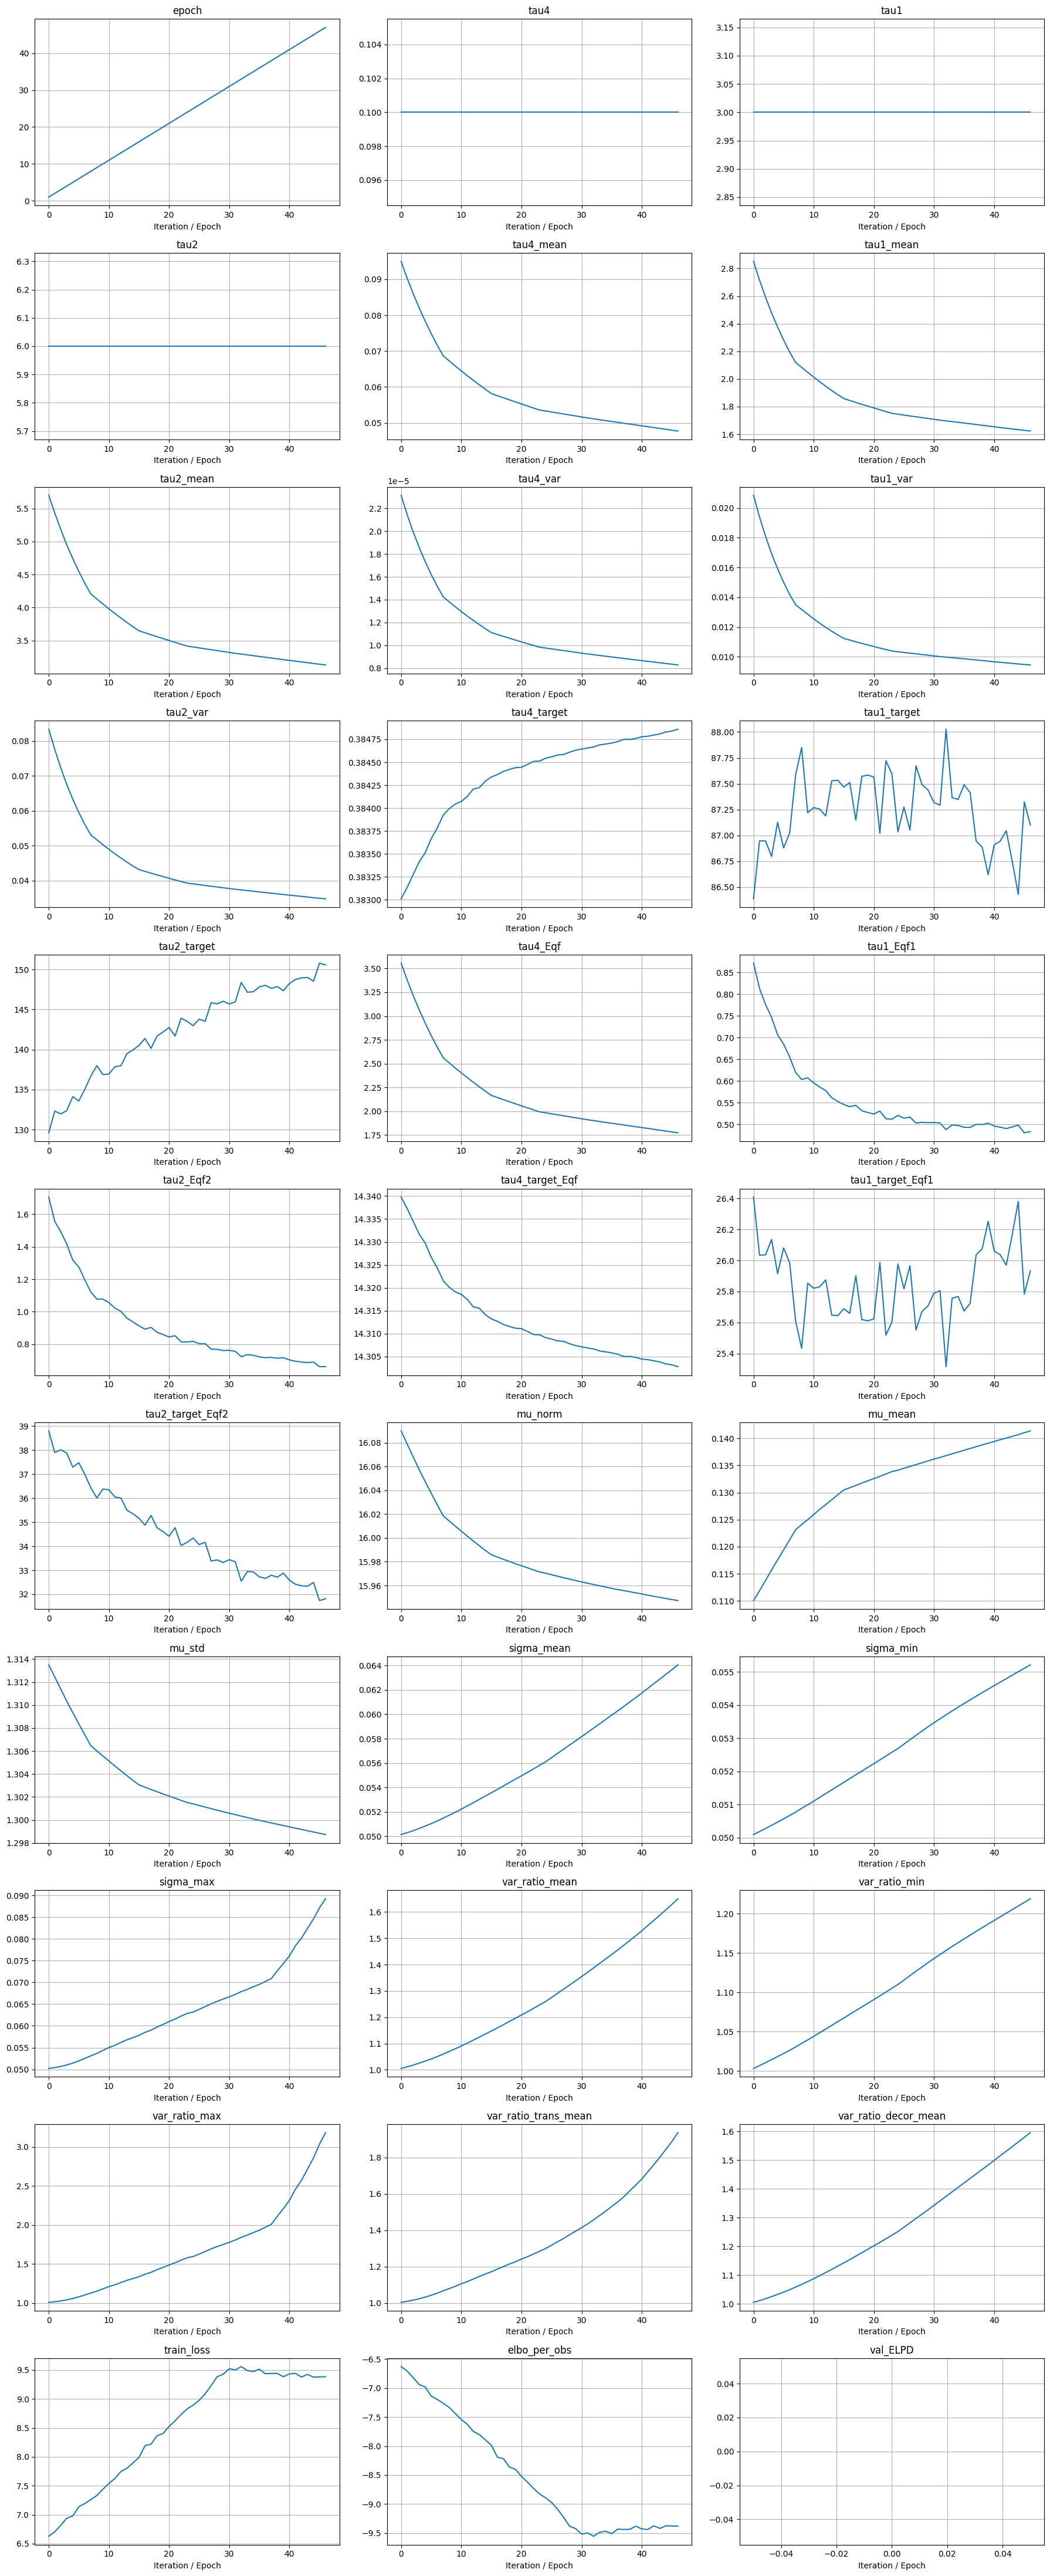

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



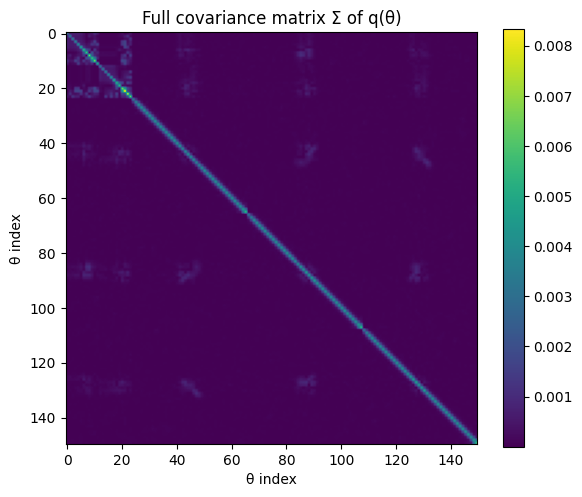

In [13]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


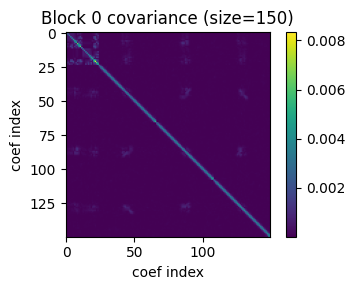

In [14]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:
import torch
import math
from torch.nn.utils.stateless import _reparametrize_module

def sample_bayesian_predictive(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    n_samples: int,
    S: int = 32,
    decor_present: bool = True,
):
    """
    Draw samples from the Bayesian predictive:
        p(y) ≈ (1/S) ∑_s p(y | θ_s, τ_s)
    by:
      - sampling θ_s ~ q(θ)
      - sampling τ_s ~ q(τ) (if tau_nodes is not None)
      - for each s, drawing n_samples/S from model with those parameters
    """
    device = model.device
    S = min(S, n_samples)
    n_per = math.ceil(n_samples / S)

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    # sample taus for each s (or fall back to hyperparameters)
    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    samples_all = []

    for s in range(S):
        theta_s = theta_samples[s]

        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            # if your sample() does not take taus, you can instead
            # stash them into model.hyperparameter[...] before calling sample
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            y_s = model.sample(n_per)  # shape [n_per, d]
            samples_all.append(y_s)

    y_cat = torch.cat(samples_all, dim=0)
    return y_cat[:n_samples]


def log_prob_bayesian_mixture(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    y: torch.Tensor, # [N, d]
    S: int = 32,
    decor_present: bool = True,
):
    """
    Compute log p(y) under the Bayesian predictive via log-mean-exp over θ, τ.
    """
    device = model.device
    N = y.shape[0]

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    logps = []

    for s in range(S):
        theta_s = theta_samples[s]
        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            # adapt this to your GTM's density API
            # e.g. if you have model.log_prob(y):
            ll_s = model.log_likelihood(y)     # [N]
            logps.append(ll_s)

    logps = torch.stack(logps, dim=0)   # [S, N]

    # log mean exp over S
    m, _ = torch.max(logps, dim=0, keepdim=True)
    log_mean = m.squeeze(0) + torch.log(torch.mean(torch.exp(logps - m), dim=0))  # [N]

    return log_mean  # [N]


In [16]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

log_likelihood_train_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_train,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_validate_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_validate,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_test_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_test,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [17]:
@torch.no_grad()
def sanity_check_covariance(VI):
    L_blocks = VI._build_L_blocks()

    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        print(f"\n[Block {b}] size={idx.numel()}")

        # shape
        print("  L.shape =", tuple(L.shape))

        # lower-triangular check
        upper = L.triu(diagonal=1)
        print("  max upper =", upper.abs().max().item())

        # diag positive?
        diag = torch.diag(L)
        print("  diag min =", diag.min().item(),
              "diag max =", diag.max().item())

        # positive definite?
        Sigma = L @ L.T
        eigvals = torch.linalg.eigvalsh(Sigma)
        print("  λ_min =", eigvals.min().item(),
              "λ_max =", eigvals.max().item(),
              "cond =", eigvals.max().item() / eigvals.min().item())

sanity_check_covariance(output["vi_model"])



[Block 0] size=150
  L.shape = (150, 150)
  max upper = 0.0
  diag min = 0.05527608469128609 diag max = 0.05530283600091934
  λ_min = 3.927902434952557e-05 λ_max = 0.016321776434779167 cond = 415.5341611731328


In [18]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [19]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1936
KLD GTM      Train Data:  0.0089
KLD Gaussian Train Data:  0.1075
KLD Copula   Train Data:  -0.0002

KLD BGTM      Test  Data:  0.1944
KLD GTM      Test  Data:  0.0179
KLD Gaussian Test  Data:  0.1102
KLD Copula   Test  Data:  0.0037


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [20]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = sample_bayesian_predictive(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    n_samples=10_000,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


In [25]:
D = VI.mu.numel()
print("D =", D)
print("num_diag =", VI.num_diag)
print("block_sizes =", VI.block_sizes)
print("L_unconstrained length =", VI.L_unconstrained.numel())

expected_tris = sum(k * (k + 1) // 2 for k in VI.block_sizes)
print("expected_tris =", expected_tris)


D = 3
num_diag = 0
block_sizes = [150]
L_unconstrained length = 11325
expected_tris = 11325


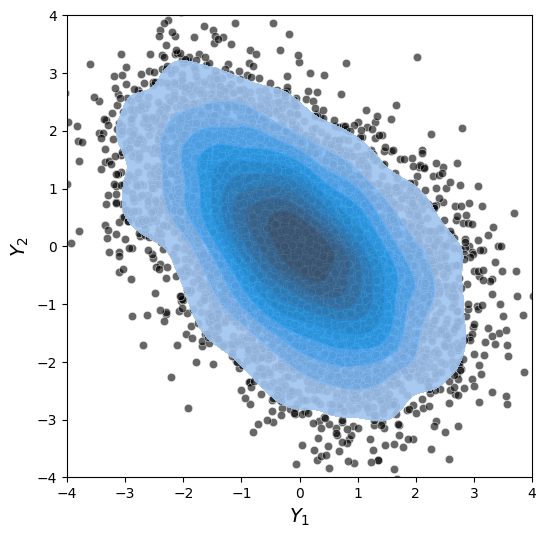

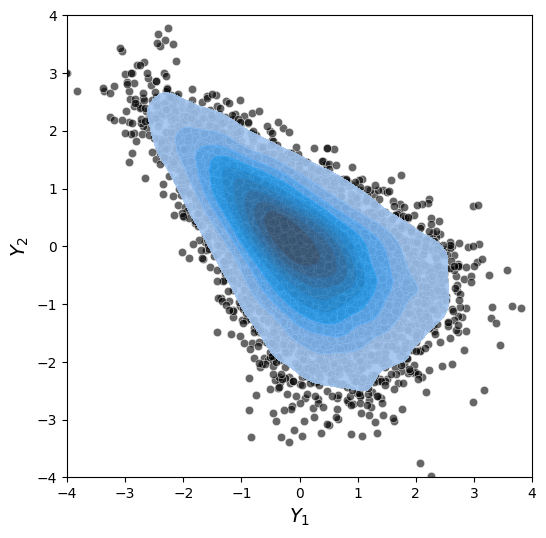

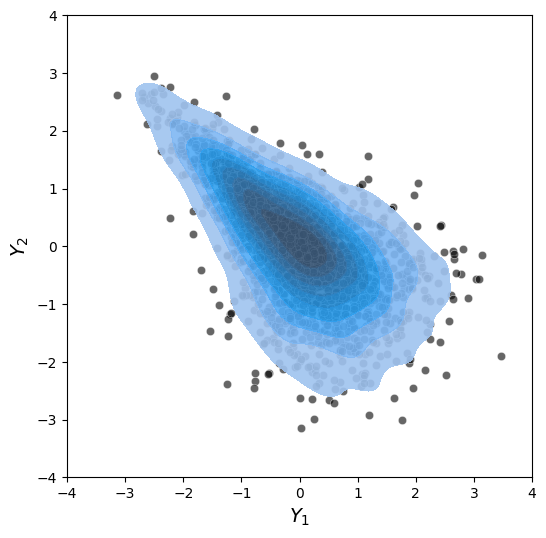

In [21]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [22]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [23]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


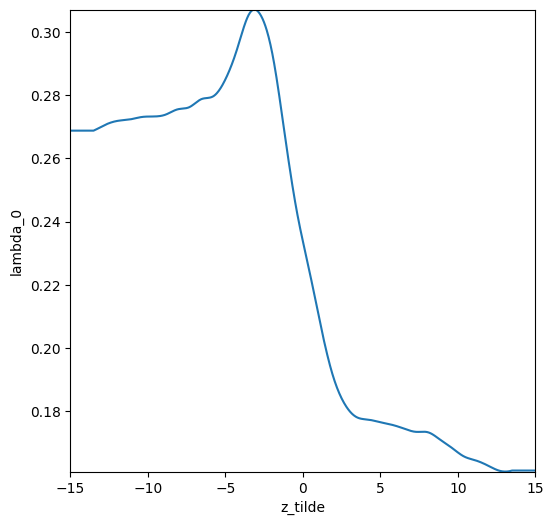

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


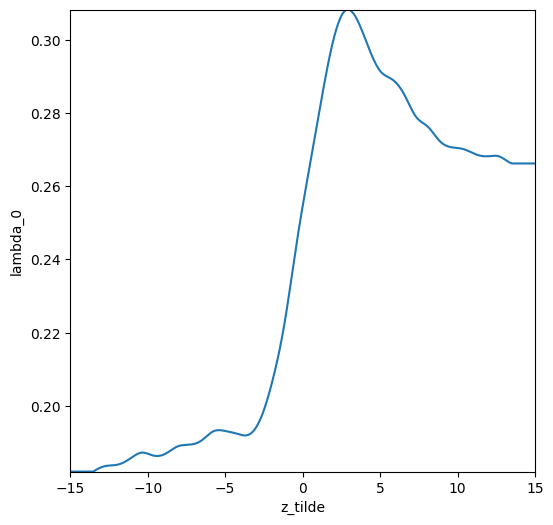

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


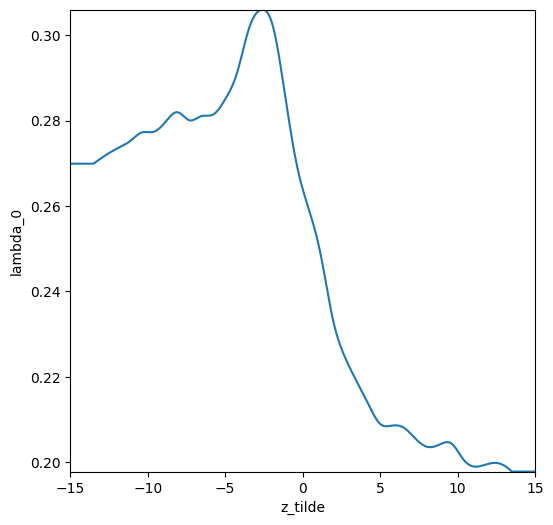

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)